# Info

https://www.kaggle.com/datasets/ahmedabelal/arabic-poetry

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import kagglehub

In [4]:
import os
import re
import json
import random

In [5]:
import tqdm
import pickle

In [6]:
!pip install arabic-reshaper python-bidi
import arabic_reshaper
from bidi.algorithm import get_display

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

import tensorflow as tf
from tensorflow.keras.utils import Sequence

2025-10-19 13:31:35.023903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760880695.445154      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760880695.584707      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Functions

In [9]:
def count_n_lines(text):
    return len(text.split('\n'))

In [10]:
def count_n_words(text):
    return len(text.split(' '))

In [11]:
def count_n_chars(text):
    return len(text)

In [12]:
def read_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.read()

    json_data = json.loads(data)
    return json_data


def write_json(file_path, data):
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

In [13]:
def read_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def write_pickle(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

# Constants

In [14]:
WINDOW_SIZE = 100

In [15]:
START_TOKEN = '#'

In [16]:
# BASE_DIR = 'drive/MyDrive/BBB'
BASE_DIR = ''

UTILS_DIR = os.path.join(BASE_DIR, 'utils')
TRAIN_DIR = os.path.join(BASE_DIR, 'train')

os.makedirs(UTILS_DIR, exist_ok=True)
os.makedirs(TRAIN_DIR, exist_ok=True)

TOKENIZER_PATH = os.path.join(UTILS_DIR, 'tokenizer.json')

In [17]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [18]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2

In [19]:
EPOCHS = 20
BATCH_SIZE = 1024

# Data Loading

In [20]:
# Download latest version
path = kagglehub.dataset_download("ahmedabelal/arabic-poetry")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/arabic-poetry


In [21]:
os.listdir(path), path

(['Arabic_poetry_dataset.csv'], '/kaggle/input/arabic-poetry')

In [22]:

df = pd.read_csv(os.path.join(path, os.listdir(path)[0] ))

# Dataset Exploration

In [23]:
pd.concat([df.head(), df.sample(5), df.tail()])

,id,category,poet_name,poem_title,poem_text
0,0,الإمارات,خلفان بن مصبح,بدت تختال في حُلل الجمالِ,بدت تختال في حُلل الجمالِ\nوجادت بالزيارة والو...
1,1,الإمارات,خلفان بن مصبح,يا طائر الشعر القرير,يا طائر الشعر القرير\nيا وحي إلهام الصدور\nأسع...
2,2,الإمارات,خلفان بن مصبح,بنت حجرات أرى من عجب,بنت حجرات أرى من عجب\nأن أرى فيك جمال العرب\nد...
3,3,الإمارات,خلفان بن مصبح,هذا الربيع بنور الحسن وافانا,هذا الربيع بنور الحسن وافانا\nوقد كسا الأرض با...
4,4,الإمارات,خلفان بن مصبح,روحي فداك وإن مُنحتُ صدوداً,روحي فداك وإن مُنحتُ صدوداً\nأخفاك ما بي أم أط...
16765,16939,العصر العباسي,أبو العلاء المعري,سكنت إلى الدنيا فلما عرفتها,سَكَنتُ إِلى الدُنيا فَلَمّا عَرَفتُها\nتَمَنّ...
11400,11574,مصر,مصطفى صادق الرافعي,آفة العالم أن لا يعملا,آفةُ العالمِ أن لا يعملا\nوشقا الجاهلِ أن لا ي...
37613,37787,عصر المخضرمون,علي بن أبي طالب,أبى الله إلا أن صفين دارنا,أَبى اللَهُ إِلّا أَنَّ صِفِّينَ دارُنا\nوَدار...
13700,13874,العصر الجاهلي,الخنساء,يا عين جودي بالدموع,يا عَينِ جودي بِالدُموعِ \nالمُستَهِلّاتِ السَ...
3272,3379,اليمن,محمد الشوكاني,كأن وجه النهر إذ حفت به,كَأَنَّ وَجْهَ النَّهْرِ إذْ حَفَّتْ بِهِ\nأَش...


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54944 entries, 0 to 54943
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54944 non-null  int64 
 1   category    54944 non-null  object
 2   poet_name   54944 non-null  object
 3   poem_title  54944 non-null  object
 4   poem_text   54944 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [25]:
df.describe(include='all')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,category,poet_name,poem_title,poem_text
count,54944.000000,54944,54944,54944,54944
unique,NaN,28,538,54300,54767
top,NaN,العصر العباسي,ابن نباته المصري,لعمري وما عمري علي بهين,ظَلَّت بِقُمَّ مَطِيَّتي يَعتادُها\nهَمّانِ غُ...
freq,NaN,10116,1726,4,2
mean,27636.214673,NaN,NaN,NaN,NaN
std,15875.618346,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN
25%,13909.750000,NaN,NaN,NaN,NaN
50%,27645.500000,NaN,NaN,NaN,NaN
75%,41381.250000,NaN,NaN,NaN,NaN


# Data Preprocessing

In [26]:
import re

def clean_poem_text(txt):
    # Normalize Arabic forms to standard letters
    arabic_normalization = {
        "أ": "ا", "إ": "ا", "آ": "ا",
        "ؤ": "و", "ئ": "ي", "ى": "ي",
        "ة": "ه", "ۀ": "ه",
        "گ": "ك", "پ": "ب", "چ": "ج",
        "ژ": "ز",
        "ی": "ي",   # Persian Yeh → Arabic Yeh
    }

    for k, v in arabic_normalization.items():
        txt = txt.replace(k, v)

    # Remove Tatweel (ـ)
    txt = txt.replace("ـ", "")

    # Remove diacritics (tashkeel)
    txt = re.sub(r'[\u064B-\u0652]', '', txt)

    # Remove English letters and digits
    txt = re.sub(r'[A-Za-z0-9]', '', txt)

    # Remove non-Arabic punctuation except (، ؛ ؟)
    txt = re.sub(r'[^\u0600-\u06FF\n،؛؟ ]', '', txt)

    # Remove tabs
    txt = re.sub(r'\t', ' ', txt)

    # Remove repeated spaces but keep newlines
    txt = re.sub(r' {2,}', ' ', txt)

    # Remove extra newlines
    txt = re.sub(r'\n{2,}', '\n', txt)

    # Trim each line
    txt = '\n'.join(line.strip() for line in txt.split('\n'))

    return txt.strip()

In [27]:
df['poem_text'] = df['poem_text'].apply(clean_poem_text)

In [28]:
df['category'] = df['category'].apply(clean_poem_text)

# Data Analysis

In [29]:
df['poem_n_lines'] = df['poem_text'].apply(count_n_lines)

In [30]:
df['poem_n_chars'] = df['poem_text'].apply(count_n_chars)

In [31]:
df['poem_n_words'] = df['poem_text'].apply(count_n_words)

# Data Visualization

In [32]:
plt.style.use(plt.style.available[12])

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Distribution of Number of Lines per Poem'}, xlabel='poem_n_lines', ylabel='Count'>

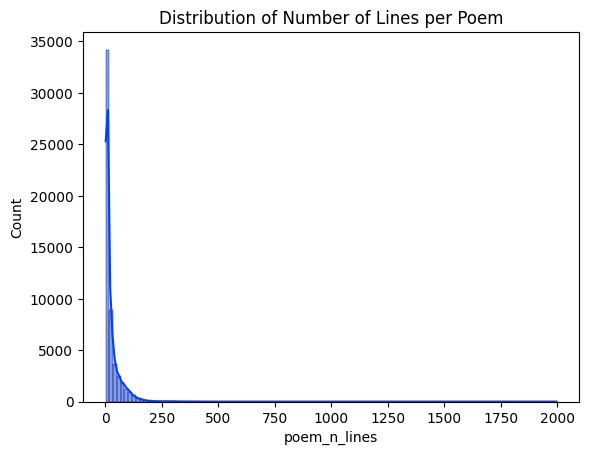

In [33]:
plt.title("Distribution of Number of Lines per Poem")
sns.histplot(data=df, x='poem_n_lines', bins=120, kde=True)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Distribution of Number of Chars per Poem'}, xlabel='poem_n_chars', ylabel='Count'>

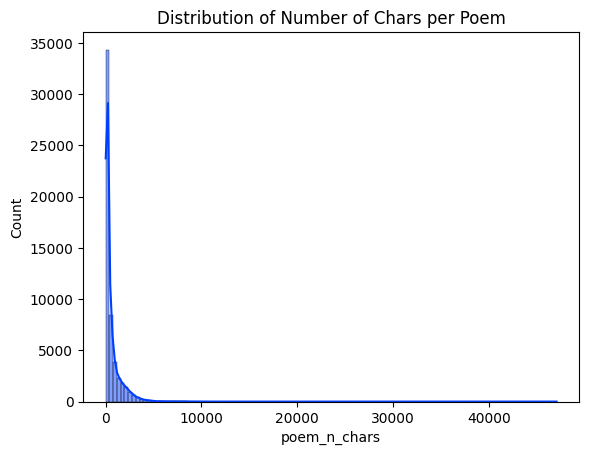

In [34]:
plt.title("Distribution of Number of Chars per Poem")
sns.histplot(data=df, x='poem_n_chars', bins=120, kde=True)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Distribution of Number of Words per Poem'}, xlabel='poem_n_words', ylabel='Count'>

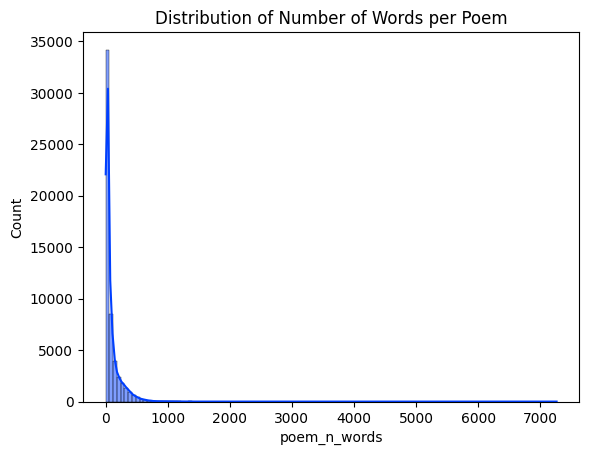

In [35]:
plt.title("Distribution of Number of Words per Poem")
sns.histplot(data=df, x='poem_n_words', bins=120, kde=True)

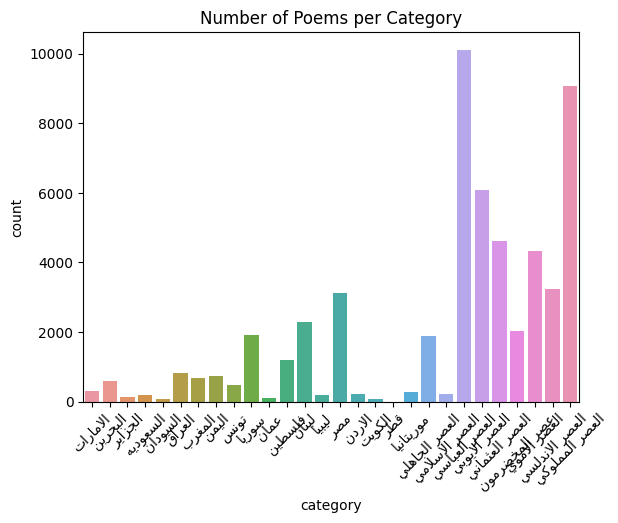

In [36]:
plt.title("Number of Poems per Category")
ax = sns.countplot(data=df, x='category')
plt.xticks(rotation=45)

labels = [t.get_text() for t in ax.get_xticklabels()]
reshaped_labels = [get_display(arabic_reshaper.reshape(l)) for l in labels]
ax.set_xticklabels(reshaped_labels, rotation=45)

plt.show()

# Tokenizer

In [37]:
if os.path.exists(TOKENIZER_PATH):
    tokenizer_dict = read_json(TOKENIZER_PATH)
    print("Loaded existing tokenizer with {} tokens.".format(len(tokenizer_dict)))
else:
    # Create tokenizer
    chars_set = set()

    for seq in tqdm.tqdm(list(df['poem_text'])):
        chars_set.update(list(seq))

    chars_list = sorted(list(chars_set))

    if START_TOKEN in chars_list:
        chars_list.remove(START_TOKEN)

    # to be at index 0
    chars_list.insert(0, START_TOKEN)

    tokenizer_dict = {ch: idx for idx, ch in enumerate(chars_list)}

    write_json(TOKENIZER_PATH, tokenizer_dict)
    print("Created new tokenizer with {} tokens.".format(len(tokenizer_dict)))

100%|██████████| 54944/54944 [00:01<00:00, 29941.56it/s]

Created new tokenizer with 35 tokens.


In [38]:
def tokenizer_decode(sequence):
  msg = ""

  for idx in sequence:
    msg += list(tokenizer_dict.keys())[list(tokenizer_dict.values()).index(idx)]

  return msg

# Data Scanner

In [39]:
scanned_windows_df = []

In [40]:
for idx, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    poem_id = row['id']
    poem_text = row['poem_text']

    n_chars = len(poem_text)

    start_i = -1 * WINDOW_SIZE + 1

    while True:
        end_i = start_i + WINDOW_SIZE

        if end_i >= n_chars:
            break

        scanned_windows_df.append(
            {
                'poem_id': poem_id,
                'start_i': start_i,
            }
        )

        start_i += 1

100%|██████████| 54944/54944 [00:18<00:00, 3049.85it/s]


In [41]:
print("Converting to DataFrame")
scanned_windows_df = pd.DataFrame(scanned_windows_df)

Converting to DataFrame


In [42]:
scanned_windows_df

,poem_id,start_i
0,0,-99
1,0,-98
2,0,-97
3,0,-96
4,0,-95
...,...,...
33779646,55117,1092
33779647,55117,1093
33779648,55117,1094
33779649,55117,1095


# Data Split

In [43]:
scanned_windows_train, scanned_windows_df_test = train_test_split(
    scanned_windows_df,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED
)

scanned_windows_df_val, scanned_windows_df_test = train_test_split(
    scanned_windows_df_test,
    test_size= TEST_SIZE / (TEST_SIZE + VAL_SIZE),
    random_state=RANDOM_SEED
)

In [44]:
print(f"Scanned Train len:  {len(scanned_windows_train):,}")
print(f"Scanned Val len:    {len(scanned_windows_df_val):,}")
print(f"Scanned Test len:   {len(scanned_windows_df_test):,}")


Scanned Train len:  27,023,720
Scanned Val len:    3,377,965
Scanned Test len:   3,377,966


# Data Loader

In [45]:
# Global cache shared across all DataLoader instances
_GLOBAL_POEM_CACHE = {}


class DataLoader(Sequence):
    def __init__(self, scanned_df, df, tokenizer_dict,
                 batch_size=BATCH_SIZE,
                 shuffle=True,
                 window_size=WINDOW_SIZE,
                 start_token=START_TOKEN,
                 drop_random=0.0):

        global _GLOBAL_POEM_CACHE

        self.scanned_df = scanned_df.reset_index(drop=True)
        self.df = df
        self.tokenizer_dict = tokenizer_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.window_size = window_size
        self.start_token = start_token
        self.drop_random = np.clip(drop_random, 0.0, 0.9)  # prevent full drop

        # Add new poems to the global cache (if not already cached)
        new_poems = df[~df['id'].isin(_GLOBAL_POEM_CACHE)]
        if len(new_poems) > 0:
            for poem_id, poem_text in zip(new_poems['id'].values, new_poems['poem_text'].values):
                _GLOBAL_POEM_CACHE[poem_id] = poem_text
            print(f"[DataLoader] Cached {len(new_poems)} new poems → total cache size: {len(_GLOBAL_POEM_CACHE)}")

        self.poem_cache = _GLOBAL_POEM_CACHE
        self.on_epoch_end()

    def __len__(self):
        effective_len = int(len(self.scanned_df) * (1 - self.drop_random))

        return effective_len // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.scanned_df.iloc[batch_indices]

        poem_ids = batch_df['poem_id'].values
        starts = batch_df['start_i'].values

        X, y = self._generate_pairs_fast(poem_ids, starts)
        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.scanned_df))

        if self.shuffle:
            np.random.shuffle(self.indices)

        # 💡 Apply drop_random to reduce samples per epoch
        if self.drop_random > 0:
            keep_n = int(len(self.indices) * (1 - self.drop_random))
            self.indices = self.indices[:keep_n]

    def _generate_pairs_fast(self, poem_ids, starts):
        X, y = [], []
        ws = self.window_size
        tdict = self.tokenizer_dict
        start_token = self.start_token
        poem_cache = self.poem_cache

        for poem_id, start_i in zip(poem_ids, starts):
            poem_text = poem_cache.get(poem_id)
            if poem_text is None:
                continue  # skip missing poem

            n_pad = -start_i if start_i < 0 else 0
            pos_start_id = max(start_i, 0)

            seq = start_token * n_pad + poem_text[pos_start_id:pos_start_id + ws - n_pad]
            if pos_start_id + ws - n_pad >= len(poem_text):
                continue  # skip incomplete window

            label = poem_text[pos_start_id + ws - n_pad]

            X.append([tdict[ch] for ch in seq])
            y.append(tdict[label])

        return np.array(X, dtype=np.int32), np.array(y, dtype=np.int32)

In [46]:
train_data_loader = DataLoader(scanned_windows_train, df, tokenizer_dict, shuffle=True, drop_random= 0.5)
val_data_loader = DataLoader(scanned_windows_df_val, df, tokenizer_dict, shuffle=False, drop_random= 0.5)
test_data_loader = DataLoader(scanned_windows_df_test, df, tokenizer_dict, shuffle=False, drop_random= 0.5)

[DataLoader] Cached 54944 new poems → total cache size: 54944


In [47]:
N_ROWS = 10
COUNTER_i = 0

batch_x, batch_y = train_data_loader[0]

for x, y in zip(batch_x, batch_y):
    if COUNTER_i >= N_ROWS:
        break
    else:
        COUNTER_i += 1

    print(f"X (length: {len(x)}):")
    print(tokenizer_decode(x))
    print(x)
    print(f"y: {y}, {tokenizer_decode([y])}")
    print()

X (length: 100):
طان
خطافه الحركات ذات مساعر
حملت جفون مراجل وجفان
كالبحر اعلاها اللهيب وقعرها
جمر كمثل سبايك العقيان
[22  7 31  1 13 22  7 26 32  2  7 29 12 16 28  7  9  2 15  7  9  2 30 18
  7 24 16  1 12 30 29  9  2 11 26 33 31  2 30 16  7 11 29  2 33 11 26  7
 31  1 28  7 29  8 12 16  2  7 24 29  7 32  7  2  7 29 29 32 34  8  2 33
 27 24 16 32  7  1 11 30 16  2 28 30 10 29  2 18  8  7 34 28  2  7 29 24
 27 34  7 31]
y: 1, 


X (length: 100):
ل كل جنس
اري ما يطمع الراجين فيه
فاطمع في نجاتك بعد ياس
سافرغ للثناء عليه فكري
واملاء القريض عليك طر
[29  2 28 29  2 11 31 18  1  7 16 34  2 30  7  2 34 22 30 24  2  7 29 16
  7 11 34 31  2 26 34 32  1 26  7 22 30 24  2 26 34  2 31 11  7  9 28  2
  8 24 14  2 34  7 18  1 18  7 26 16 25  2 29 29 10 31  7  6  2 24 29 34
 32  2 26 28 16 34  1 33  7 30 29  7  6  2  7 29 27 16 34 21  2 24 29 34
 28  2 22 16]
y: 18, س

X (length: 100):
 حيث تم ما قصد
وتسعه بها المزيد ينجلي
فقد النظير مطلقا كتتفل
وحذفه من اصل او نظير او
فرع لغير عله كم
[ 2 12 34 10  2

# Encapsulated Models

## Encapsulate

In [48]:
class HistoryCheckpoint(Callback):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.filepath = os.path.join(TRAIN_DIR, f'{model_name}.history.json')
        self.history = {}

        if os.path.exists(self.filepath):
            with open(self.filepath, 'r') as f:
                self.history = json.load(f)
                print(F'Model {self.model_name} history loaded from cache')
        else:
            self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            self.history.setdefault(key, []).append(float(value))

        with open(self.filepath, 'w') as f:
            json.dump(self.history, f)

    def get_history(self):
        return self.history

In [49]:
class CustomModel:
    def __init__(self, name, model):
        self.name = re.sub('[^A-Za-z0-9]', '_', str(name)).lower()
        self.model_weights_path = os.path.join(TRAIN_DIR, f'{self.name}.weights.h5')
        self.model = model
        self._history = {}
        self.load()

    def fit(self, train_data, val_data, epochs=EPOCHS, force_train=False):
        """
        train_data: either (X_train, y_train) tuple or a generator
        val_data: either (X_val, y_val) tuple or a generator
        """

        es = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
        
        mcp = ModelCheckpoint(
            filepath=self.model_weights_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            mode='min',
            verbose=1
        )
        
        rop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
        
        hcp = HistoryCheckpoint(self.name)

        if not self.trained or force_train:

            history = self.model.fit(
                train_data,
                validation_data=val_data,
                callbacks=[es, mcp, rop, hcp],
                epochs=epochs,
                verbose=1
            )

            self.trained = True
            self._history = hcp.get_history() or getattr(history, "history", {})
            self.save()
        else:
            self._history = hcp.get_history()

    @property
    def history(self):
        return self._history

    def save(self):
        self.model.save_weights(self.model_weights_path)

    def load(self):
        if os.path.exists(self.model_weights_path):
            self.model.load_weights(self.model_weights_path)
            self.trained = True
            print(f'Model {self.name} weights loaded from cache')
        else:
            self.trained = False
            print(f'Model {self.name} weights not found in cache, training required')

        hcp = HistoryCheckpoint(self.name)
        self._history = hcp.get_history()


## Layers

In [50]:
def create_input_layer():
    return Input(shape= train_data_loader[0][0].shape[1:] )

In [51]:
def create_embedding_layer(embedding_dim):
    return Embedding(
        input_dim = len(tokenizer_dict),
        output_dim = embedding_dim,
        mask_zero=False
    )

In [52]:
def positional_encoding(seq_len, d_model):
    positions = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
    dims = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]
    angle_rates = 1 / tf.pow(10000., (2 * (dims // 2)) / d_model)
    angle_rads = positions * angle_rates
    sines = tf.sin(angle_rads[:, 0::2])
    cosines = tf.cos(angle_rads[:, 1::2])
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    return pos_encoding[tf.newaxis, ...]

## Models

In [53]:
models_list = []

In [54]:
# def build_model_1():
#     global models_list

#     NAME = "RNN v1"

#     input_layer = create_input_layer()
#     embedding_layer = create_embedding_layer(16)

#     x = embedding_layer(input_layer)

#     x = LSTM(128, return_sequences=False)(x)

#     output_layer = Dense(len(tokenizer_dict), activation='softmax')(x)

#     model = Model(inputs=input_layer, outputs=output_layer)

#     model.compile(
#         loss='sparse_categorical_crossentropy',
#         optimizer='adam',
#         metrics=['accuracy']
#     )

#     c_model = CustomModel(
#         name=NAME,
#         model=model
#     )

#     model.summary()

#     models_list.append(c_model)

# build_model_1()

In [55]:
# def build_model_2():
#     global models_list

#     NAME = "RNN v2"

#     input_layer = create_input_layer()
#     embedding_layer = create_embedding_layer(32)

#     x = embedding_layer(input_layer)

#     x = LSTM(256, return_sequences=True)(x)

#     x = LSTM(256, return_sequences=False)(x)

#     output_layer = Dense(len(tokenizer_dict), activation='softmax')(x)

#     model = Model(inputs=input_layer, outputs=output_layer)

#     model.compile(
#         loss='sparse_categorical_crossentropy',
#         optimizer='adam',
#         metrics=['accuracy']
#     )

#     c_model = CustomModel(
#         name=NAME,
#         model=model
#     )

#     model.summary()

#     models_list.append(c_model)

# build_model_2()

In [56]:
# def build_model_3():
#     global models_list

#     NAME = "RNN v3"

#     input_layer = create_input_layer()
#     embedding_layer = create_embedding_layer(48)

#     x = embedding_layer(input_layer)

#     x = Bidirectional(LSTM(256, return_sequences=True))(x)

#     x = Bidirectional(LSTM(256, return_sequences=False))(x)

#     output_layer = Dense(len(tokenizer_dict), activation='softmax')(x)

#     model = Model(inputs=input_layer, outputs=output_layer)

#     model.compile(
#         loss='sparse_categorical_crossentropy',
#         optimizer='adam',
#         metrics=['accuracy']
#     )

#     c_model = CustomModel(
#         name=NAME,
#         model=model
#     )

#     model.summary()

#     models_list.append(c_model)

# build_model_3()

In [57]:
# def build_model_4():
#     global models_list

#     NAME = "Encoder v1"

#     vocab_size = len(tokenizer_dict) + 1  # +1 for CLS token
#     d_model = 128
#     seq_len = 60  # sequence length

#     # 1️⃣ Input layer
#     input_layer = Input(shape=(seq_len,), dtype=tf.int32)

#     # 2️⃣ Add CLS token to the beginning
#     def add_cls_fn(x):
#         batch_size = tf.shape(x)[0]
#         cls = tf.fill((batch_size, 1), vocab_size - 1)  # CLS token index
#         return tf.concat([cls, x], axis=1)

#     add_cls = Lambda(add_cls_fn, output_shape=(seq_len + 1,))(input_layer)

#     # 3️⃣ Embedding layer
#     embedding_layer = Embedding(vocab_size, d_model)(add_cls)

#     # 🔹 Conv1D (light local context before attention)
#     x = Conv1D(
#         filters=d_model,
#         kernel_size=3,
#         padding="same",
#         activation="relu"
#     )(embedding_layer)

#     # 4️⃣ Positional Encoding (precomputed and dtype-safe)
#     pos_encoding = tf.cast(positional_encoding(seq_len + 1, d_model), tf.float32)

#     x = Lambda(
#         lambda t: t + pos_encoding[:tf.shape(t)[1], :],
#         output_shape=(None, d_model)
#     )(x)

#     # 5️⃣ Multi-Head Attention
#     attn_output = MultiHeadAttention(num_heads=4, key_dim=d_model)(x, x)

#     # 6️⃣ Skip Connection + Layer Normalization
#     x = Add()([x, attn_output])
#     x = LayerNormalization(epsilon=1e-6)(x)

#     # 🟢 Extract CLS token before Feed Forward
#     cls_token = Lambda(lambda x: x[:, 0], output_shape=(d_model,))(x)

#     # 7️⃣ Feed-Forward Network (CLS only)
#     ff = Dense(d_model * 4, activation='relu')(cls_token)
#     ff = Dense(d_model)(ff)
#     ff = LayerNormalization(epsilon=1e-6)(ff)

#     # 8️⃣ Output Layer
#     output_layer = Dense(len(tokenizer_dict), activation='softmax')(ff)

#     # ✅ Build & Compile model
#     model = Model(inputs=input_layer, outputs=output_layer)

#     model.compile(
#         loss='sparse_categorical_crossentropy',
#         optimizer='adam',
#         metrics=['accuracy']
#     )

#     # Register model in your list
#     c_model = CustomModel(name=NAME, model=model)
#     model.summary()
#     models_list.append(c_model)


# # Example call
# build_model_4()

In [58]:
def build_model_5():
    global models_list

    NAME = "Encoder v2 - Compact Fixed"

    vocab_size = len(tokenizer_dict) + 2  # +2 for CLS tokens
    d_model = 32
    seq_len = WINDOW_SIZE

    # 1️⃣ Input
    input_layer = Input(shape=(seq_len,), dtype=tf.int32)

    # 2️⃣ Add 2 CLS tokens
    def add_cls_fn(x):
        batch_size = tf.shape(x)[0]
        cls_tokens = tf.fill((batch_size, 2), vocab_size - 2)
        return tf.concat([cls_tokens, x], axis=1)

    x = Lambda(add_cls_fn, output_shape=(seq_len + 2,))(input_layer)

    # 3️⃣ Embedding
    x = Embedding(vocab_size, d_model)(x)

    # 4️⃣ Parallel Conv1D
    convs = []
    for k in [1, 3, 5, 7]:
        conv = Conv1D(filters=d_model , kernel_size=k, padding="same", activation="relu")(x)
        convs.append(conv)
    x = Concatenate()(convs)
    proj_dim = x.shape[-1]

    # 5️⃣ Positional Encoding
    pos_encoding = tf.cast(positional_encoding(seq_len + 2, proj_dim), tf.float32)
    x = Lambda(
        lambda t: t + pos_encoding[:tf.shape(t)[1], :],
        output_shape=(seq_len + 2, proj_dim)
    )(x)

    # 6️⃣ Multi-head attention
    attn_output = MultiHeadAttention(num_heads=8, key_dim=proj_dim // 8)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization(epsilon=1e-6)(x)

    # 7️⃣ Extract CLS tokens
    cls_tokens = Lambda(lambda t: t[:, :2], output_shape=(2, proj_dim))(x)

    # 8️⃣ Cross product
    def cross_product_fn(t):
        v1 = t[:, 0, :]
        v2 = t[:, 1, :]
        v1 = tf.expand_dims(v1, axis=2)
        v2 = tf.expand_dims(v2, axis=1)
        return tf.matmul(v1, v2)  # (batch, d, d)

    x = Lambda(cross_product_fn, output_shape=(proj_dim, proj_dim))(cls_tokens)

    # ✅ Wrap expand_dims in Lambda
    x = Lambda(lambda t: tf.expand_dims(t, -1), output_shape=(proj_dim, proj_dim, 1))(x)
    x = Flatten()(x)

    # 9️⃣ Compact Feed-forward
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    # 🔟 Output
    output_layer = Dense(len(tokenizer_dict), activation='softmax')(x)

    # Build & compile
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
        metrics=['accuracy']
    )

    # Register
    c_model = CustomModel(name=NAME, model=model)
    models_list.append(c_model)
    model.summary()


build_model_5()

I0000 00:00:1760880772.222991      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760880772.223754      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model encoder_v2___compact_fixed weights not found in cache, training required


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 102)       │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 102, 32)   │      1,184 │ lambda[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 102, 32)   │      1,056 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 102, 32)   │      3,104 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 102, 32)   │      5,152 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 102, 32)   │      7,200 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 102, 128)  │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 102, 128)  │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 102, 128)  │     66,048 │ lambda_1[0][0],   │
│ (MultiHeadAttentio… │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 102, 128)  │          0 │ lambda_1[0][0],   │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 102, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 2, 128)    │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 128, 128)  │          0 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 128, 128,  │          0 │ lambda_3[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  4,194,560 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     16,448 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 35)        │      2,275 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,297,283 (16.39 MB)

 Trainable params: 4,297,283 (16.39 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
for model in models_list:
    keras_model = model.model

    img_path = os.path.join(TRAIN_DIR,f'{model.name}_arch.png')

    plot_model(
        keras_model,
        to_file= img_path,
        show_shapes=True,
        dpi =200,
        show_layer_names=True,
        expand_nested=True,
        show_layer_activations=True,
        show_trainable=True,
        show_dtype=True,
    )

# Train

In [60]:
for i, model in enumerate(models_list):
    print(F"Training Model {i+1}/{len(models_list)}: {model.name}")

    model.fit(
        train_data_loader,
        val_data_loader,
        force_train=False,
    )

Training Model 1/1: encoder_v2___compact_fixed


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1760880784.407035      71 service.cc:148] XLA service 0x7a08bc015b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760880784.408771      71 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760880784.408787      71 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760880785.083729      71 cuda_dnn.cc:529] Loaded cuDNN version 90300


    1/13195 ━━━━━━━━━━━━━━━━━━━━ 62:14:34 17s/step - accuracy: 0.0537 - loss: 4.1641

I0000 00:00:1760880795.537634      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13195/13195 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2686 - loss: 2.6120
Epoch 1: val_loss improved from inf to 2.17249, saving model to train/encoder_v2___compact_fixed.weights.h5
13195/13195 ━━━━━━━━━━━━━━━━━━━━ 1171s 87ms/step - accuracy: 0.2686 - loss: 2.6120 - val_accuracy: 0.3901 - val_loss: 2.1725 - learning_rate: 3.0000e-04
Epoch 2/20
13195/13195 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3974 - loss: 2.1402
Epoch 2: val_loss improved from 2.17249 to 2.04949, saving model to train/encoder_v2___compact_fixed.weights.h5
13195/13195 ━━━━━━━━━━━━━━━━━━━━ 1163s 88ms/step - accuracy: 0.3974 - loss: 2.1402 - val_accuracy: 0.4202 - val_loss: 2.0495 - learning_rate: 3.0000e-04
Epoch 3/20
13195/13195 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4266 - loss: 2.0221
Epoch 3: val_loss improved from 2.04949 to 1.96187, saving model to train/encoder_v2___compact_fixed.weights.h5
13195/13195 ━━━━━━━━━━━━━━━━━━━━ 1170s 89ms/step - accuracy: 0.4266 - loss: 2.0221 - val_accuracy: 0

# History

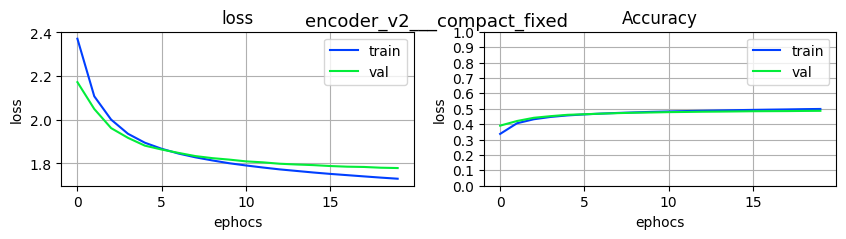

In [61]:
for i, model in enumerate(models_list):
    plt.figure(figsize=(10,2))


    plt.subplot(1, 2, 1)

    plt.suptitle(f"{model.name}", fontsize=13)


    plt.grid(True)
    plt.title(f"loss")
    plt.ylabel('loss')
    plt.xlabel('ephocs')
    plt.plot(model.history['loss'], label='train')
    plt.plot(model.history['val_loss'], label='val')
    plt.legend()

    plt.subplot(1, 2, 2)

    plt.grid(True)
    plt.title(f"Accuracy")
    plt.ylabel('loss')
    plt.xlabel('ephocs')
    plt.plot(model.history['accuracy'], label='train')
    plt.plot(model.history['val_accuracy'], label='val')
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend()

    plt.show()

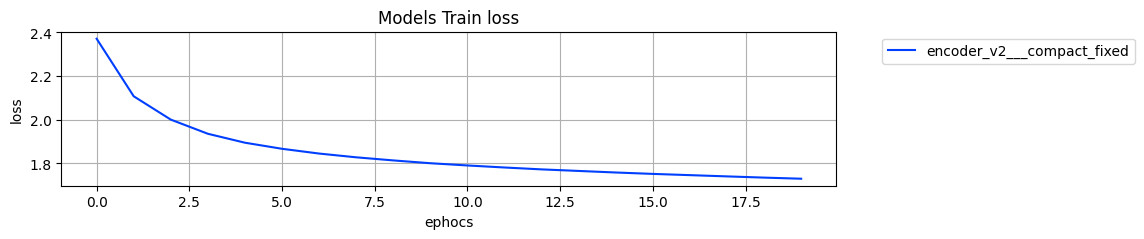

In [62]:
plt.figure(figsize=(10,2))
plt.title(f"Models Train loss")
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('ephocs')

for i, model in enumerate(models_list):
    plt.plot(model.history['loss'], label=model.name)

plt.legend(bbox_to_anchor=(1.05, 1),
            loc="upper left",)
plt.show()

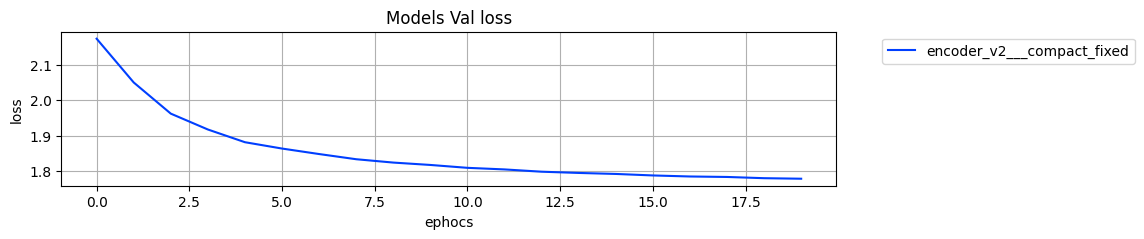

In [63]:
plt.figure(figsize=(10,2))
plt.title(f"Models Val loss")
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('ephocs')

for i, model in enumerate(models_list):
    plt.plot(model.history['val_loss'], label=model.name)

plt.legend(bbox_to_anchor=(1.05, 1),
            loc="upper left",)

plt.show()

# Inference

In [64]:
best_model_name = "encoder_v2___compact_fixed"
best_model = list(filter(lambda x: x.name == best_model_name, models_list))[0]
print(best_model)

In [65]:
def predict_txt(input_prompt, best_model, iterations, sample_p = True):
    padded_prompt = clean_poem_text(input_prompt)

    yield padded_prompt

    while(len(padded_prompt) < WINDOW_SIZE):
        padded_prompt = START_TOKEN + padded_prompt
        
    while(len(padded_prompt) > WINDOW_SIZE):
        padded_prompt = padded_prompt[1:]

    for i in range(iterations):
        padded_prompt_tokenized = [tokenizer_dict[ch] for ch in padded_prompt]

        padded_prompt_tokenized = np.array([padded_prompt_tokenized])
        pro_output =  best_model.predict(padded_prompt_tokenized, verbose = 0)[0]

        if sample_p:
            ch_num = np.random.choice(len(pro_output), p=pro_output)
        else:
            ch_num = np.argmax(pro_output)
        ch = tokenizer_decode([ch_num])[0]

        padded_prompt = padded_prompt[1:] + ch

        yield ch

        
    return ch

In [66]:
for r in predict_txt("يا عبير", best_model.model, 500, False):
    print(r,end='')

يا عبير الموت الذي انت المني
والمرء من الامر المنير
والمرء يعرف من الامال وال
انا المساعي المنير المسير
والماء المعالي والمرايا
والموت الا ان تكون المسير
والموت المنايا المنيه
والموت المنايا المستقيم
والال المساعي المنيف المني
والماء من المنصب المعدوم
والال والاحسان ان المني
والموت المنايا والتقديم
والال المعاني والمنايا
والموت المنايا والمستقيم
والامر المعالي والمعالي
والموت المنايا والمستقيم
والارض ترجع من الانام
والارض المنير والمستقيم
والارض ترجف والاحسام
والال والاحسان الا المعاني
والموت المنايا و

# Cache